[![deep-learning-notes](https://github.com/semilleroCV/deep-learning-notes/raw/main/assets/banner-notebook.png)](https://github.com/semilleroCV/deep-learning-notes)

In [130]:
#@title **import required libraries**.
import torch # '2.2.1'
import torch.nn as nn # '2.2.1'
import math # 3.10.12

Here you will find the implementation together with a very detailed visual explanation of the attention module proposed in "Attention is all you need", the version used in the Vision Transformers (ViT) can be found [here](https://github.com/semilleroCV/deep-learning-notes/blob/main/notebooks/architectures/vit.ipynb)

They found it beneficial to linearly project the queries, keys and values h (`num_heads`) times with different, learned linear projections to d_k, d_k and d_v dimensions, respectively. On each of these projected versions of queries, keys and values we then perform the attention function in parallel, yielding d_v-dimensional output values. These are concatenated and once again projected, resulting in the final values, as depicted in the figure.

<div align="center"> <image src="https://production-media.paperswithcode.com/methods/multi-head-attention_l1A3G7a.png" width=300>  </div>

**Scaled Dot-Product Attention**: The input consists of queries and keys of dimension d_k, and values of dimension d_v. We compute the dot products of the query with all keys, divide each by √d_k, and apply a softmax function to obtain the weights on the values. In practice, we compute the attention function on a set of queries simultaneously, packed together into a matrix Q. The keys and values are also packed together into matrices K and V . We compute the matrix of outputs as (here d_ff = 2, d_k = d_v = 3):

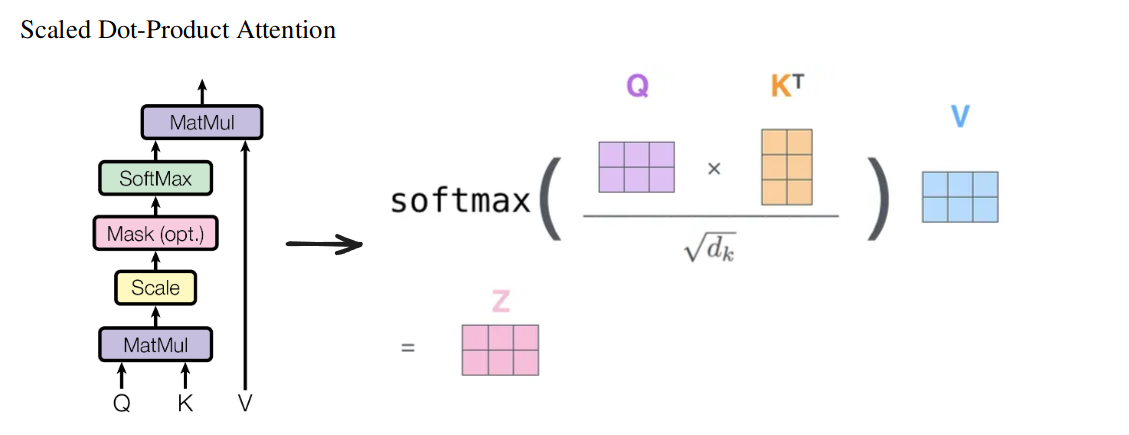

Where do Q, K and V come from? Simply, it is to take the matrix of the sentence X and project it linearly with W_q, W_k and W_v (here d_model =4, d_ff = 2, d_k = d_v = 3).

<div align="center"> <image src="https://imgs.search.brave.com/qghth1IekFyJ3FBI1f9eWCzJZG1DDoSitUddg13jIYM/rs:fit:860:0:0:0/g:ce/aHR0cHM6Ly9qYWxh/bW1hci5naXRodWIu/aW8vaW1hZ2VzL3Qv/c2VsZi1hdHRlbnRp/b24tbWF0cml4LWNh/bGN1bGF0aW9uLnBu/Zw" width=300>  </div>

At the end, all the z matrices (one for each head) are concatenated and multiplied by W_o of dimensions h*d_v rows and d_model columns, to obtain the output which will have the same dimensions as the input (here h=8).

<div align="center"> <image src="https://jalammar.github.io/images/t/transformer_attention_heads_weight_matrix_o.png" width=500>  </div>

See https://jalammar.github.io/illustrated-transformer/ for a more detailed explanation.

In [131]:
class MultiheadAttention(nn.Module):
  """Some Information about MultiheadAttention"""
  def __init__(self, d_model:int = 512, num_heads:int = 8, bias:bool=False):
    super(MultiheadAttention, self).__init__()
    
    # We make sure that the division is integer.
    assert d_model % num_heads == 0, "Size not compatible with number of heads"

    self.num_heads = num_heads
    self.d_v = d_model//num_heads
    self.d_k = self.d_v

    # In order not to have to make h matrices we will "extend" them from d_k to d_model
    # that is, d_k, h times.
    self.W_q = nn.Linear(d_model, self.d_k * num_heads, bias=bias)
    self.W_k = nn.Linear(d_model, self.d_k * num_heads, bias=bias)
    self.W_v = nn.Linear(d_model, self.d_k * num_heads, bias=bias)
    self.W_o = nn.Linear(self.d_v * num_heads, d_model, bias=bias)

  def forward(self, Q, K, V, mask = None):

    batch_size = Q.size(0)

    Q, K, V = self.W_q(Q), self.W_k(K), self.W_v(V)
    Q = Q.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)  # here we are "deconcatenating" the Querys for each head.
    K = K.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
    V = V.view(batch_size, -1, self.num_heads, self.d_v).transpose(1, 2)

    """ 
      Q, K and V -> [batch_size, seq_len, d_k * num_heads]
      after transpose Q, K and V -> [batch_size, num_heads, seq_len, d_k]
    """

    weighted_values, attention = self.scaled_dot_pruduct_attention(Q, K, V, mask)

    # contiguous() will rearrange the memory allocation so that the tensor is C contiguous https://stackoverflow.com/questions/48915810/what-does-contiguous-do-in-pytorch
    weighted_values = weighted_values.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads*self.d_k) # we have to concatenate the output of the scaled_dot_product

    """
    weighted_values -> [batch_size, num_heads, seq_len, d_k]
    after transpose weighted_values -> [batch_size, seq_len, num_heads * d_k]
    """

    weighted_values = self.W_o(weighted_values) # [batch_size, seq_len, d_model]

    return weighted_values, attention
  
  def scaled_dot_pruduct_attention(self, Q, K, V, mask = None):
      
      # matmul operates for each head
      compatibility = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k) # the transpose here is, as in the paper, so that the multiplication between matrices can be done

      if mask is not None:
         compatibility = compatibility.masked_fill(mask == 0, -float('inf')) # pay attention only to the tokens we are interested in

      attention = nn.Softmax(dim=-1)(compatibility) # dim=-1 is to be applied for each vector of q, k and v, [batch_size, num_heads, seq_len, seq_len]
      weighted_values = torch.matmul(attention, V)
      return weighted_values, attention

A more visual and detailed explanation of what is happening in the code is as follows:
1. First imagine that we have a sentence with two words (tokens)
2. Initially we have to get the querys (`Q`), keys (`K`) and the values (`V`), for this we multiply the input `x` by `W_q`, `W_k` and `W_v`.
3. Because the weight matrices (`W_q`, `W_k`, `W_v`) were extended to not have to make h matrices we have to 'deconcatenate' them to be able to apply the `scaled_dot_product_attention` function for each head in parallel, to my knowledge, there are two methods to do this (one more intuitive than the other, the demonstration that they do exactly the same can be found in the annexes of this notebook)

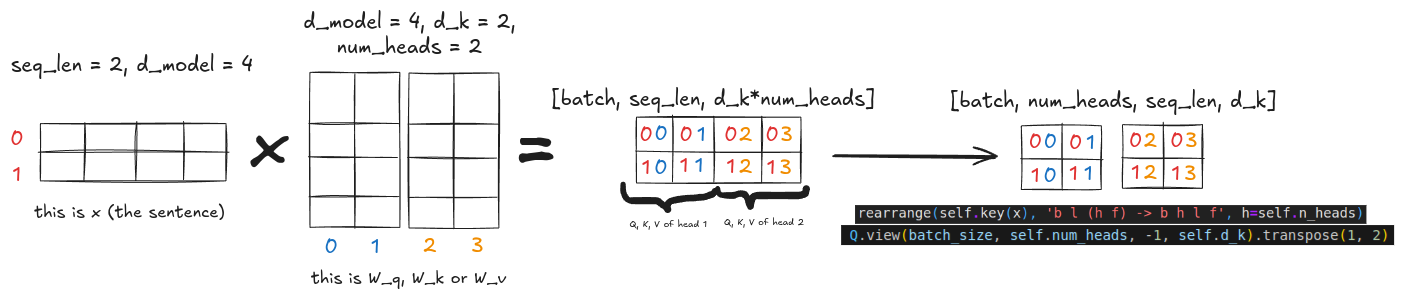

4. At this point we must apply `scaled_dot_product_attention` to each of the heads to find the attention scores, the dimensions of each operation are detailed in the image. 

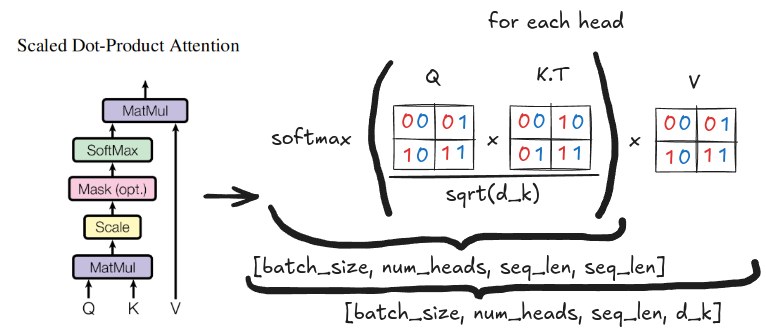

5. At the end we will have the matrices with the attention scores for each head, but in order to make the linear projection at the end of the module we must 'concatenate' them again, basically performing the inverse process of step 3. Again, there are two methods to do this (in the annexes is the demonstration that they do exactly the same). The output will be an array that captures information from all the attention heads to be sent (originally) to the PositionWiseFeedForward module.

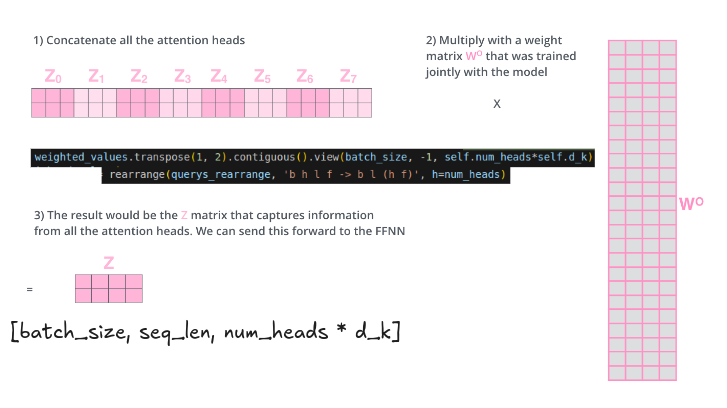

### example with random embeddings

dimensions

In [132]:
d_model = 4 # dimensions of the model
d_ff = 5 # number of tokens per sentence
num_heads = 2

word embeddings

In [133]:
torch.manual_seed(2024)
# for this demo we are going to use random embeddings,
# refer to word embeddings at https://github.com/semilleroCV/deep-learning-notes/blob/main/notebooks/data_exploration/glove-word-embeddings.ipynb

# the example word gonna be: me gusta estudiar inteligencia artificial
me = torch.randn(d_model)
gusta = torch.randn(d_model)
estudiar = torch.randn(d_model)
inteligencia = torch.randn(d_model)
artificial = torch.randn(d_model)
print(me)

tensor([-0.0404,  1.7260, -0.8140,  1.3722])


positional encodings

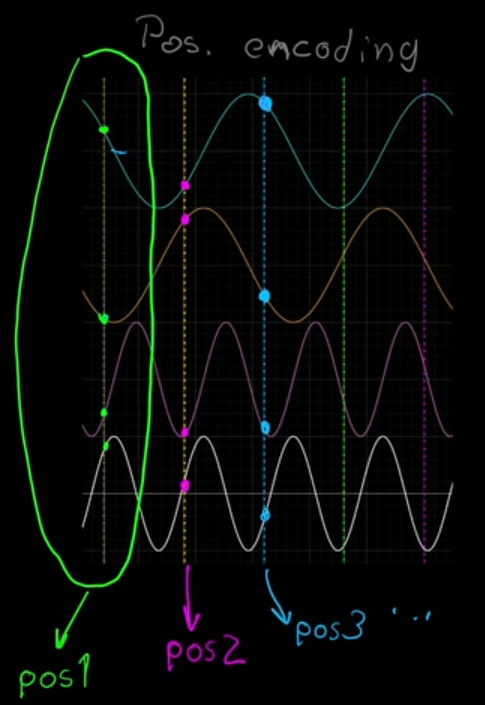

What is happening here is that to each word embedding we add the respective values of each function for its corresponding trace or dash. With this we make sure to preserve or 'encode' the position of the words in the original sentence. For the demo, we will assume the following values.

In [134]:
pos_1 = torch.asarray([0.3, -0.9, -0.6, 0.8])
pos_2 = torch.asarray([-0.6, 0.8, -0.9, 0.15])
pos_3 = torch.asarray([0.8, -0.5, -0.9, 0.5])
pos_4 = torch.asarray([-0.95, 0.2, -0.4, -0.9])
pos_5 = torch.asarray([0.95, 0.16, 0.2, -0.95])

# we add it to te embeddings
me+=pos_1
gusta+=pos_2
estudiar+=pos_3
inteligencia+=pos_4
artificial+=pos_5
print(me)

tensor([ 0.2596,  0.8260, -1.4140,  2.1722])


In [135]:
sentence = torch.cat([me, gusta, estudiar, inteligencia, artificial]).view(d_ff, -1).unsqueeze(0)
print(sentence, sentence.size())

tensor([[[ 0.2596,  0.8260, -1.4140,  2.1722],
         [-0.0940,  0.3177, -1.6853,  0.8181],
         [ 0.3561, -0.3112, -0.3014,  1.1458],
         [-0.3194, -1.2668, -1.0798, -1.5970],
         [ 1.7393, -0.7712, -1.7368, -1.1572]]]) torch.Size([1, 5, 4])


In [136]:
# this module has already been implemented in torch.nn, let's compare it with ours!
embed_dim = d_model
pytorch_multihead_attn = nn.MultiheadAttention(embed_dim, num_heads, bias=False)

our_multihead_attn = MultiheadAttention(d_model, num_heads, bias=False)

In [137]:
weighted_values, attention = our_multihead_attn(sentence, sentence, sentence)

print(weighted_values, weighted_values.size())

tensor([[[-0.0219,  0.0755, -0.0344,  0.0364],
         [-0.0179,  0.0571, -0.0267,  0.0263],
         [-0.0096,  0.0182,  0.0097,  0.0155],
         [ 0.0124, -0.0339,  0.0512,  0.0033],
         [ 0.0512, -0.1337,  0.1452, -0.0182]]], grad_fn=<UnsafeViewBackward0>) torch.Size([1, 5, 4])


In [138]:
attn_output, attn_output_weights = pytorch_multihead_attn(sentence, sentence, sentence)

print(attn_output, attn_output.size())

tensor([[[-0.0603, -0.3477,  0.2211, -0.2508],
         [-0.1368,  0.0297,  0.1521, -0.2765],
         [-0.1226, -0.1779,  0.1326, -0.1041],
         [-0.2948,  0.5957,  0.0150, -0.1869],
         [-0.4603,  0.1770,  0.3523, -0.2488]]], grad_fn=<ViewBackward0>) torch.Size([1, 5, 4])


At the moment I only care that **the dimensions are the same**. The outputs may not match due to differences in the implementation of internal layers, numerical precision, or the way PyTorch handles operations such as scaling, softmax, and matrix multiplication.

### references

- Pepe Cantoral, Ph.D. (2024, June 20). Transformers - ¡Attention is all you need! Parte 2 [Video]. YouTube. https://www.youtube.com/watch?v=Nj5DVykeFhM
- Alammar, J. (n.d.). The illustrated transformer. https://jalammar.github.io/illustrated-transformer/
- Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., Kaiser, L., & Polosukhin, I. (2017, June 12). Attention is all you need. arXiv.org. https://arxiv.org/abs/1706.03762
- Phillips, H. (2023, May 14). Multi-Head Attention - Hunter Phillips - Medium. Medium. https://medium.com/@hunter-j-phillips/multi-head-attention-7924371d477a
- MultiheadAttention — PyTorch 2.4 documentation. (n.d.). https://pytorch.org/docs/stable/generated/torch.nn.MultiheadAttention.html

### annexes

#### demonstration that rearrange does the same as transpose+view

In [139]:
from einops import rearrange # 0.8.0

d_model, seq_len, num_heads, d_k = 4, 2, 2, 2

a = torch.arange(0, d_model*2).view(-1, d_model).float() # the sentence
b = torch.triu(torch.ones(d_model, num_heads*2)) # simulated W_q, W_k, W_v
print(a)
print(b)
querys = (a @ b).unsqueeze(0)
print(querys, querys.size())

tensor([[0., 1., 2., 3.],
        [4., 5., 6., 7.]])
tensor([[1., 1., 1., 1.],
        [0., 1., 1., 1.],
        [0., 0., 1., 1.],
        [0., 0., 0., 1.]])
tensor([[[ 0.,  1.,  3.,  6.],
         [ 4.,  9., 15., 22.]]]) torch.Size([1, 2, 4])


deconcatenating

In [140]:
querys_view = querys.view(1, -1, num_heads, d_k).transpose(1, 2)
print(querys_view, querys_view.size())

tensor([[[[ 0.,  1.],
          [ 4.,  9.]],

         [[ 3.,  6.],
          [15., 22.]]]]) torch.Size([1, 2, 2, 2])


In [141]:
querys_rearrange = rearrange(querys, 'b l (h f) -> b h l f', h=num_heads)
print(querys_rearrange, querys_rearrange.size())

tensor([[[[ 0.,  1.],
          [ 4.,  9.]],

         [[ 3.,  6.],
          [15., 22.]]]]) torch.Size([1, 2, 2, 2])


concatenating

In [142]:
querys_concat_view = querys_view.transpose(1, 2).contiguous().view(1, -1, num_heads * d_k)
print(querys_concat_view, querys_concat_view.size())

tensor([[[ 0.,  1.,  3.,  6.],
         [ 4.,  9., 15., 22.]]]) torch.Size([1, 2, 4])


In [143]:
querys_concat_rearrange = rearrange(querys_rearrange, 'b h l f -> b l (h f)', h=num_heads)
print(querys_concat_rearrange)

tensor([[[ 0.,  1.,  3.,  6.],
         [ 4.,  9., 15., 22.]]])


#### visualization of attention probabilities

In [144]:
import matplotlib.pyplot as plt # 3.5.1

def display_attention(sentence: list, translation: list, attention: torch.Tensor, 
                      n_heads: int = 8, n_rows: int = 4, n_cols: int = 2):
  """
    Display the attention matrix for each head of a sequence. 
    White is closer to 1, and black is closer to 0.

    Args:
        sentence:     German sentence to be translated to English; list
        translation:  English sentence predicted by the model
        attention:    attention scores for the heads
        n_heads:      number of heads
        n_rows:       number of rows
        n_cols:       number of columns
  """
  # ensure the number of rows and columns are equal to the number of heads
  assert n_rows * n_cols == n_heads
    
  # figure size
  fig = plt.figure(figsize=(15,20))
    
  # visualize each head
  for i in range(n_heads):
        
    # create a plot
    ax = fig.add_subplot(n_rows, n_cols, i+1)
        
    # select the respective head and make it a numpy array for plotting
    _attention = attention.squeeze(0)[i,:,:].cpu().detach().numpy()

    # plot the matrix
    cax = ax.matshow(_attention, cmap='bone')

    # set the size of the labels
    ax.tick_params(labelsize=12)

    # set the indices for the tick marks
    ax.set_xticks(range(len(sentence)))
    ax.set_yticks(range(len(translation)))

    ax.set_xticklabels(sentence)
    ax.set_yticklabels(translation)

  plt.show()

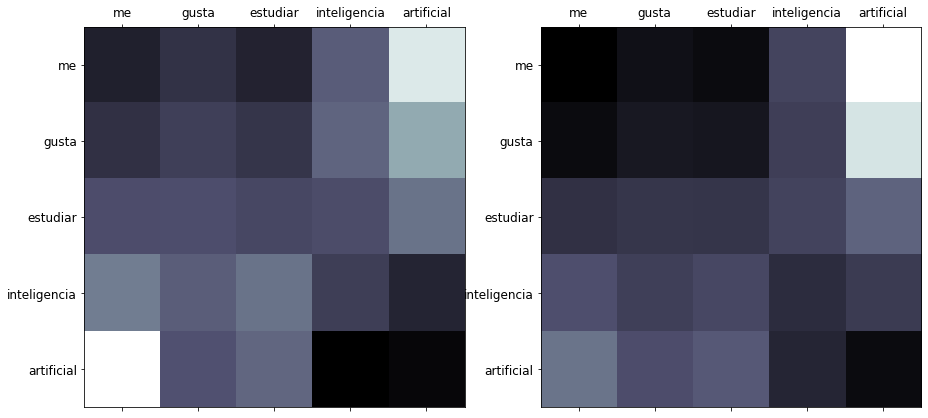

In [145]:
display_attention(["me", "gusta", "estudiar", "inteligencia", "artificial"], 
                  ["me", "gusta", "estudiar", "inteligencia", "artificial"], 
                  attention[0], 2, 1, 2)